# GLM: Clicks to Decision Variable - Sklearn Implementation (Single-Window v003)


In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# GLM libraries - using sklearn ElasticNetCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Set random seed for reproducibility
np.random.seed(42)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Built-in standardization enabled (no sklearn StandardScaler needed)")

Built-in standardization enabled (no sklearn StandardScaler needed)


## 1. Data Loading and Preparation

Load session data and filter to first 240 trials.

In [222]:
# Data paths configuration
PROJECT_ROOT = Path('/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV')
SESSION_ID = 'A324'
SESSION_DATE = '2023-07-27'  # Using the date from the plan

# Path to processed H5 file (this is what we'll actually use)
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'processed' / SESSION_ID / SESSION_DATE
H5_FILE = OUTPUT_DIR / f'{SESSION_ID}_{SESSION_DATE}_session_data.h5'

# Verify H5 file exists
if not H5_FILE.exists():
    raise FileNotFoundError(f"Processed H5 file not found: {H5_FILE}")

print(f"Project root: {PROJECT_ROOT}")
print(f"Session: {SESSION_ID} ({SESSION_DATE})")
print(f"H5 file: {H5_FILE}")
print(f"H5 file size: {H5_FILE.stat().st_size / 1024 / 1024:.1f} MB")

Project root: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV
Session: A324 (2023-07-27)
H5 file: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/A324_2023-07-27_session_data.h5
H5 file size: 154.2 MB


In [223]:
def load_session_data(h5_file_path=None):
    """
    Load session data from H5 file and return DataFrames
    
    Args:
        h5_file_path: Path to H5 file (uses global H5_FILE if None)
    
    Returns:
        trial_df: Trial metadata
        click_df: Click events data  
        dv_df: Decision variables data
    """
    if h5_file_path is None:
        h5_file_path = H5_FILE
    
    if not h5_file_path.exists():
        raise FileNotFoundError(f"Data file not found: {h5_file_path}")
    
    print(f"Loading data from: {h5_file_path}")
    
    # Use pandas HDFStore to load the data
    with pd.HDFStore(h5_file_path, mode='r') as store:
        trial_df = store.get('trials')
        click_df = store.get('clicks')
        dv_df = store.get('decision_variables')
    
    print(f"Loaded {len(trial_df)} trials, {len(click_df)} clicks, {len(dv_df)} DV points")
    
    return trial_df, click_df, dv_df

In [224]:
# Load full session data
trial_df, click_df, dv_df = load_session_data()

click_df_joined = click_df.join(trial_df.set_index('trial_id'), on='trial_id', rsuffix='_trial')
dv_df_joined = dv_df.join(trial_df.set_index('trial_id'), on='trial_id', rsuffix='_trial')

min_session_trials = 240

# Filter to first 900 trials
trial_df_240 = trial_df[trial_df['original_trial_num'] < min_session_trials].copy()
click_df_240 = click_df_joined[click_df_joined['original_trial_num'] < min_session_trials].copy()
dv_df_240 = dv_df_joined[dv_df_joined['original_trial_num'] < min_session_trials].copy()

print(f"\nFiltered to first {min_session_trials} trials:")
print(f"Trials: {len(trial_df_240)}")
print(f"Clicks: {len(click_df_240)}")
print(f"DV points: {len(dv_df_240)}")
print(f"Valid DV points: {dv_df_240['is_valid'].sum()}")

Loading data from: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/A324_2023-07-27_session_data.h5
Loaded 774 trials, 22144 clicks, 17028 DV points

Filtered to first 240 trials:
Trials: 186
Clicks: 5272
DV points: 4092
Valid DV points: 3255


In [225]:
# Data validation and exploration
print("Click distribution:")
print(click_df_240['click_side'].value_counts())

print("\nDV statistics:")
valid_dvs = dv_df_240[dv_df_240['is_valid']]
print(f"DV range: [{valid_dvs['decision_variable'].min():.3f}, {valid_dvs['decision_variable'].max():.3f}]")
print(f"DV mean: {valid_dvs['decision_variable'].mean():.3f}")
print(f"DV std: {valid_dvs['decision_variable'].std():.3f}")

print("\nTrial duration statistics:")
trial_durations = trial_df_240.groupby('trial_id')['trial_duration'].first()
print(f"Duration range: [{trial_durations.min():.2f}, {trial_durations.max():.2f}] seconds")
print(f"Mean duration: {trial_durations.mean():.2f} seconds")

Click distribution:
click_side
left     2798
right    2474
Name: count, dtype: int64

DV statistics:
DV range: [-31.808, 31.767]
DV mean: -0.247
DV std: 9.322

Trial duration statistics:
Duration range: [1.50, 1.93] seconds
Mean duration: 1.68 seconds


## 2. Design Gaussian Basis Functions

Create temporal kernels to capture click history at different timescales.

In [226]:
# Define basis function parameters - SIMPLIFIED: varying widths only
n_basis = 10  # Number of Gaussian basis functions
width_min = 0.01  # Minimum width (10ms)
width_max = 0.5   # Maximum width (500ms)

# Log-spaced widths for basis functions (no centers needed!)
widths = np.logspace(np.log10(width_min), np.log10(width_max), n_basis)

# Calculate centers with half-width offset spacing
offset_to_width_ratio = 0.25
centers = np.zeros(n_basis)
centers[0] = widths[0] * offset_to_width_ratio  # First center at half its width
for i in range(1, n_basis):
    # Each center offset by half-width of previous and current
    centers[i] = centers[i-1] + offset_to_width_ratio * (widths[i-1] + widths[i])

# Add small random offsets to break regularity
centers = centers + np.random.uniform(-0.01, 0.01, n_basis)
# Scale centers to fit in reasonable range (up to 400ms)
# if centers[-1] > 0.4:
#     centers = centers * (0.4 / centers[-1])

print(f"Centers range from {centers[0]*1000:.1f}ms to {centers[-1]*1000:.1f}ms")
print(f"Widths range from {widths[0]*1000:.1f}ms to {widths[-1]*1000:.1f}ms")

print(f"Created {n_basis} basis functions")
print(f"Width range: {width_min*1000:.1f} - {width_max*1000:.1f} ms")
print(f"Widths (ms): {(widths*1000).round(1)}")

def gaussian_basis(t, center, width, causal=True):
    """
    Gaussian basis function centered at specified time
    
    Args:
        t: Time points (0 = click time)
        center: Center of Gaussian (time after click)
        width: Width (standard deviation) of Gaussian
        causal: If True, zero out negative times (before click)
    
    Returns:
        Normalized Gaussian values at times t
    """
    # Gaussian basis function centered at specified time
    # Gaussian centered at "center" ms after click
    gaussian = (1/(width * np.sqrt(2*np.pi))) * np.exp(-(t - center)**2 / (2 * width**2))

    # gaussian = np.exp(-(t - center)**2 / (2 * width**2))

    
    if causal:
        # Only keep t>=0 (after click)
        gaussian = np.where(t >= 0, gaussian, 0)
    
    return gaussian

def split_left_right_features(X):
    """Split feature matrix into left and right features."""
    n_features = X.shape[1]
    n_basis = n_features // 2
    left_features = X[:, :n_basis]
    right_features = X[:, n_basis:]
    return left_features, right_features



Centers range from -0.0ms to 579.2ms
Widths range from 10.0ms to 500.0ms
Created 10 basis functions
Width range: 10.0 - 500.0 ms
Widths (ms): [ 10.   15.4  23.9  36.8  56.9  87.9 135.7 209.6 323.7 500. ]


## 3. Feature Engineering: Convolve Clicks with Basis Functions

For each DV time point, create feature vectors by convolving click history with Gaussian basis functions.

In [227]:
def create_click_kernel(dt=0.001):
    """
    Create a kernel matching the actual click shape:
    3ms cosine envelope as used in the behavioral experiment.

    Args:
        dt: Time step in seconds (default 1ms = 0.001s)

    Returns:
        envelope: Normalized cosine envelope array
    """
    # 3ms total width matching actual click duration
    click_duration = 0.003  # 3ms
    n_samples = int(np.ceil(click_duration / dt))
    t = np.linspace(0, click_duration, n_samples)

    # Raised cosine (Hann window) - matches the cosine envelope used in experiment
    envelope = 0.5 * (1 - np.cos(2 * np.pi * t / click_duration))

    # Normalize to preserve total energy (sum = 1)
    envelope = envelope / envelope.sum()

    return envelope

def create_trial_features(trial_clicks_left, trial_clicks_right, dv_eval_times, centers, widths,
                         trial_duration, store_convolutions=False):
    """
    Create feature matrix for single-window GLM approach.

    This simplified version:
    1. Creates fine temporal bins at 1ms resolution for entire trial duration
    2. Places 3ms cosine-shaped clicks (matching actual acoustic stimuli) at click times
    3. Convolves with causal Gaussian basis functions (varying widths)
    4. Samples at each DV evaluation time (no temporal offsets)

    Args:
        trial_clicks_left: Array of left click times (in seconds, relative to trial start)
        trial_clicks_right: Array of right click times (in seconds, relative to trial start)
        dv_eval_times: Array of times at which to evaluate features (DV time points)
        centers: Centers for basis functions (all set to 0 for causal)
        widths: Array of widths for Gaussian basis functions
        trial_duration: Total trial duration in seconds
        store_convolutions: If True, return convolution results for visualization

    Returns:
        If store_convolutions=False:
            features_matrix: (n_dv_times, n_features) array where
                           n_features = 2 * n_basis (left and right)
        If store_convolutions=True:
            features_matrix, stored_convolutions dict
    """
    # Fine temporal binning parameters - 1ms for proper click representation
    dt = 0.001  # 1ms resolution to capture 3ms clicks properly

    # Add padding at beginning and end for boundary handling
    padding_duration = 1.0  # 1 second padding on each side
    total_duration = trial_duration + 2 * padding_duration

    # Create time axis for entire padded trial
    n_bins = int(total_duration / dt)
    time_axis = np.arange(n_bins) * dt - padding_duration  # Shift so trial starts at t=0

    # Initialize click trains (padded)
    left_train = np.zeros(n_bins)
    right_train = np.zeros(n_bins)

    # Create click kernel for 3ms cosine envelope
    click_kernel = create_click_kernel(dt)

    # Place left clicks
    for click_time in trial_clicks_left:
        if 0 <= click_time <= trial_duration:
            bin_idx = int((click_time + padding_duration) / dt)
            for i, amplitude in enumerate(click_kernel):
                if 0 <= bin_idx + i < n_bins:
                    left_train[bin_idx + i] += amplitude

    # Place right clicks
    for click_time in trial_clicks_right:
        if 0 <= click_time <= trial_duration:
            bin_idx = int((click_time + padding_duration) / dt)
            for i, amplitude in enumerate(click_kernel):
                if 0 <= bin_idx + i < n_bins:
                    right_train[bin_idx + i] += amplitude

    # Apply Gaussian convolutions
    n_basis = len(widths)
    convolved_left = []
    convolved_right = []

    for i in range(n_basis):
        # Create causal Gaussian kernel centered at specified offset
        # Kernel extends 6 standard deviations from click time
        max_lag = min(6 * widths[i], padding_duration)
        kernel_n_bins = int(np.ceil(max_lag / dt)) + 1
        
        # Time since click: 0 = click time, dt = one bin after, etc.
        time_lags = np.arange(0, kernel_n_bins * dt, dt)
        
        # Create Gaussian centered at specified offset (peak at center[i] after click)
        causal_kernel = gaussian_basis(time_lags, centers[i], widths[i], causal=True)
        
        # Convolve clicks with causal kernel - FLIP kernel for proper causality
        # np.convolve doesn't flip the kernel, so we need to flip it manually
        # to get proper causal behavior (response AFTER click, not before)
        conv_left = np.convolve(left_train, causal_kernel, mode='full')[:n_bins]
        conv_right = np.convolve(right_train, causal_kernel, mode='full')[:n_bins]

        convolved_left.append(conv_left)
        convolved_right.append(conv_right)

    # Build feature matrix by sampling at DV times
    n_dv_times = len(dv_eval_times)
    features_matrix = np.zeros((n_dv_times, 2 * n_basis))

    if store_convolutions:
        # Store unpadded portion for visualization
        unpadded_start = int(padding_duration / dt)
        unpadded_end = int((trial_duration + padding_duration) / dt)
        stored_convolutions = {
            'time_grid': time_axis[unpadded_start:unpadded_end],  # Fixed: no need to add padding
            'left_train': left_train[unpadded_start:unpadded_end],
            'right_train': right_train[unpadded_start:unpadded_end],
            'left': [c[unpadded_start:unpadded_end] for c in convolved_left],
            'right': [c[unpadded_start:unpadded_end] for c in convolved_right],
            'left_click_times': trial_clicks_left,  # Store actual click times used
            'right_click_times': trial_clicks_right  # Store actual click times used
        }

    # Sample features at each DV evaluation time
    for j, dv_time in enumerate(dv_eval_times):
        # Find corresponding bin in padded representation
        sample_bin = int((dv_time + padding_duration) / dt)

        if 0 <= sample_bin < n_bins:
            # Extract features - first all left, then all right
            for i in range(n_basis):
                features_matrix[j, i] = convolved_left[i][sample_bin]
            for i in range(n_basis):
                features_matrix[j, n_basis + i] = convolved_right[i][sample_bin]

    if store_convolutions:
        return features_matrix, stored_convolutions
    else:
        return features_matrix

# Test the simplified implementation
test_trial = 5
trial_clicks = click_df_240[click_df_240['trial_id'] == test_trial]
trial_dvs = dv_df_240[dv_df_240['trial_id'] == test_trial]

left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values
trial_duration = trial_dvs['time_bin'].max() + 0.05

if len(trial_dvs) > 0:
    dv_times = trial_dvs['time_bin'].values

    # Test single-window approach
    features_matrix, stored_convs = create_trial_features(
        left_clicks, right_clicks, dv_times, centers, widths, trial_duration,
        store_convolutions=True
    )

    print(f"\nFeatures matrix shape: {features_matrix.shape}")
    print(f"Expected shape: ({len(dv_times)}, {2 * n_basis})")
    print(f"Features: {n_basis} left + {n_basis} right = {2 * n_basis} total")
    print(f"Features range: [{features_matrix.min():.4f}, {features_matrix.max():.4f}]")
    print(f"Test trial {test_trial}: {len(left_clicks)} left clicks, {len(right_clicks)} right clicks")
    print("✓ Single-window feature extraction implemented!")
    print("\nFixed: Flipped convolution kernels for proper causality")


Features matrix shape: (22, 20)
Expected shape: (22, 20)
Features: 10 left + 10 right = 20 total
Features range: [0.0000, 66.8040]
Test trial 5: 5 left clicks, 8 right clicks
✓ Single-window feature extraction implemented!

Fixed: Flipped convolution kernels for proper causality


In [228]:
# Build feature matrix X and target vector y for all trials
print("Building feature matrix with single-window approach...")

X = []
y = []
valid_mask = []
trial_ids = []
time_bins = []

# Progress tracking
from tqdm import tqdm

# Only process first 240 trials as specified
n_trials_to_process = min(min_session_trials, dv_df_240['trial_id'].max() + 1)

for trial_id in tqdm(range(n_trials_to_process), desc="Processing trials"):
    # Get clicks for this trial - use time_from_first_click to match test above
    trial_clicks = click_df_240[click_df_240['trial_id'] == trial_id]
    left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
    right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values
    
    # Get DVs for this trial
    trial_dvs = dv_df_240[dv_df_240['trial_id'] == trial_id]
    
    if len(trial_dvs) > 0:
        # Extract DV evaluation times 
        dv_eval_times = trial_dvs['time_bin'].values
        
        # Get trial duration from DV data (max time_bin represents time_from_first_click)
        # Add small buffer to ensure we capture the full trial
        trial_duration = trial_dvs['time_bin'].max() + 0.05  # 50ms buffer
        
        # Use multi-window feature creation
        try:
            features_matrix = create_trial_features(
                left_clicks, right_clicks, dv_eval_times, centers, widths, 
                trial_duration, store_convolutions=False
            )
            
            # Add features and targets for all DV time points in this trial
            for i, (_, dv_row) in enumerate(trial_dvs.iterrows()):
                X.append(features_matrix[i])
                y.append(dv_row['decision_variable'])
                valid_mask.append(dv_row['is_valid'])
                trial_ids.append(trial_id)
                time_bins.append(dv_row['time_bin'])
                
        except Exception as e:
            print(f"Warning: Error processing trial {trial_id}: {e}")
            # Skip this trial if there's an error
            continue

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
valid_mask = np.array(valid_mask)
trial_ids = np.array(trial_ids)
time_bins = np.array(time_bins)

print(f"Feature matrix constructed with multi-window approach:")
print(f"Total observations: {len(X)}")
print(f"Features per observation: {X.shape[1]} ({n_basis} basis × 2 sides)")
print(f"Valid observations: {valid_mask.sum()}")
print(f"Invalid observations: {(~valid_mask).sum()}")

# Keep only valid DV points
X_valid = X[valid_mask]
y_valid = y[valid_mask]
trial_ids_valid = trial_ids[valid_mask]
time_bins_valid = time_bins[valid_mask]

print(f"Final dataset for GLM:")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"Data covers {len(np.unique(trial_ids_valid))} unique trials")



Building feature matrix with single-window approach...


Processing trials: 100%|██████████| 186/186 [00:01<00:00, 129.13it/s]

Feature matrix constructed with multi-window approach:
Total observations: 4092
Features per observation: 20 (10 basis × 2 sides)
Valid observations: 3255
Invalid observations: 837
Final dataset for GLM:
X_valid shape: (3255, 20)
y_valid shape: (3255,)
Data covers 186 unique trials


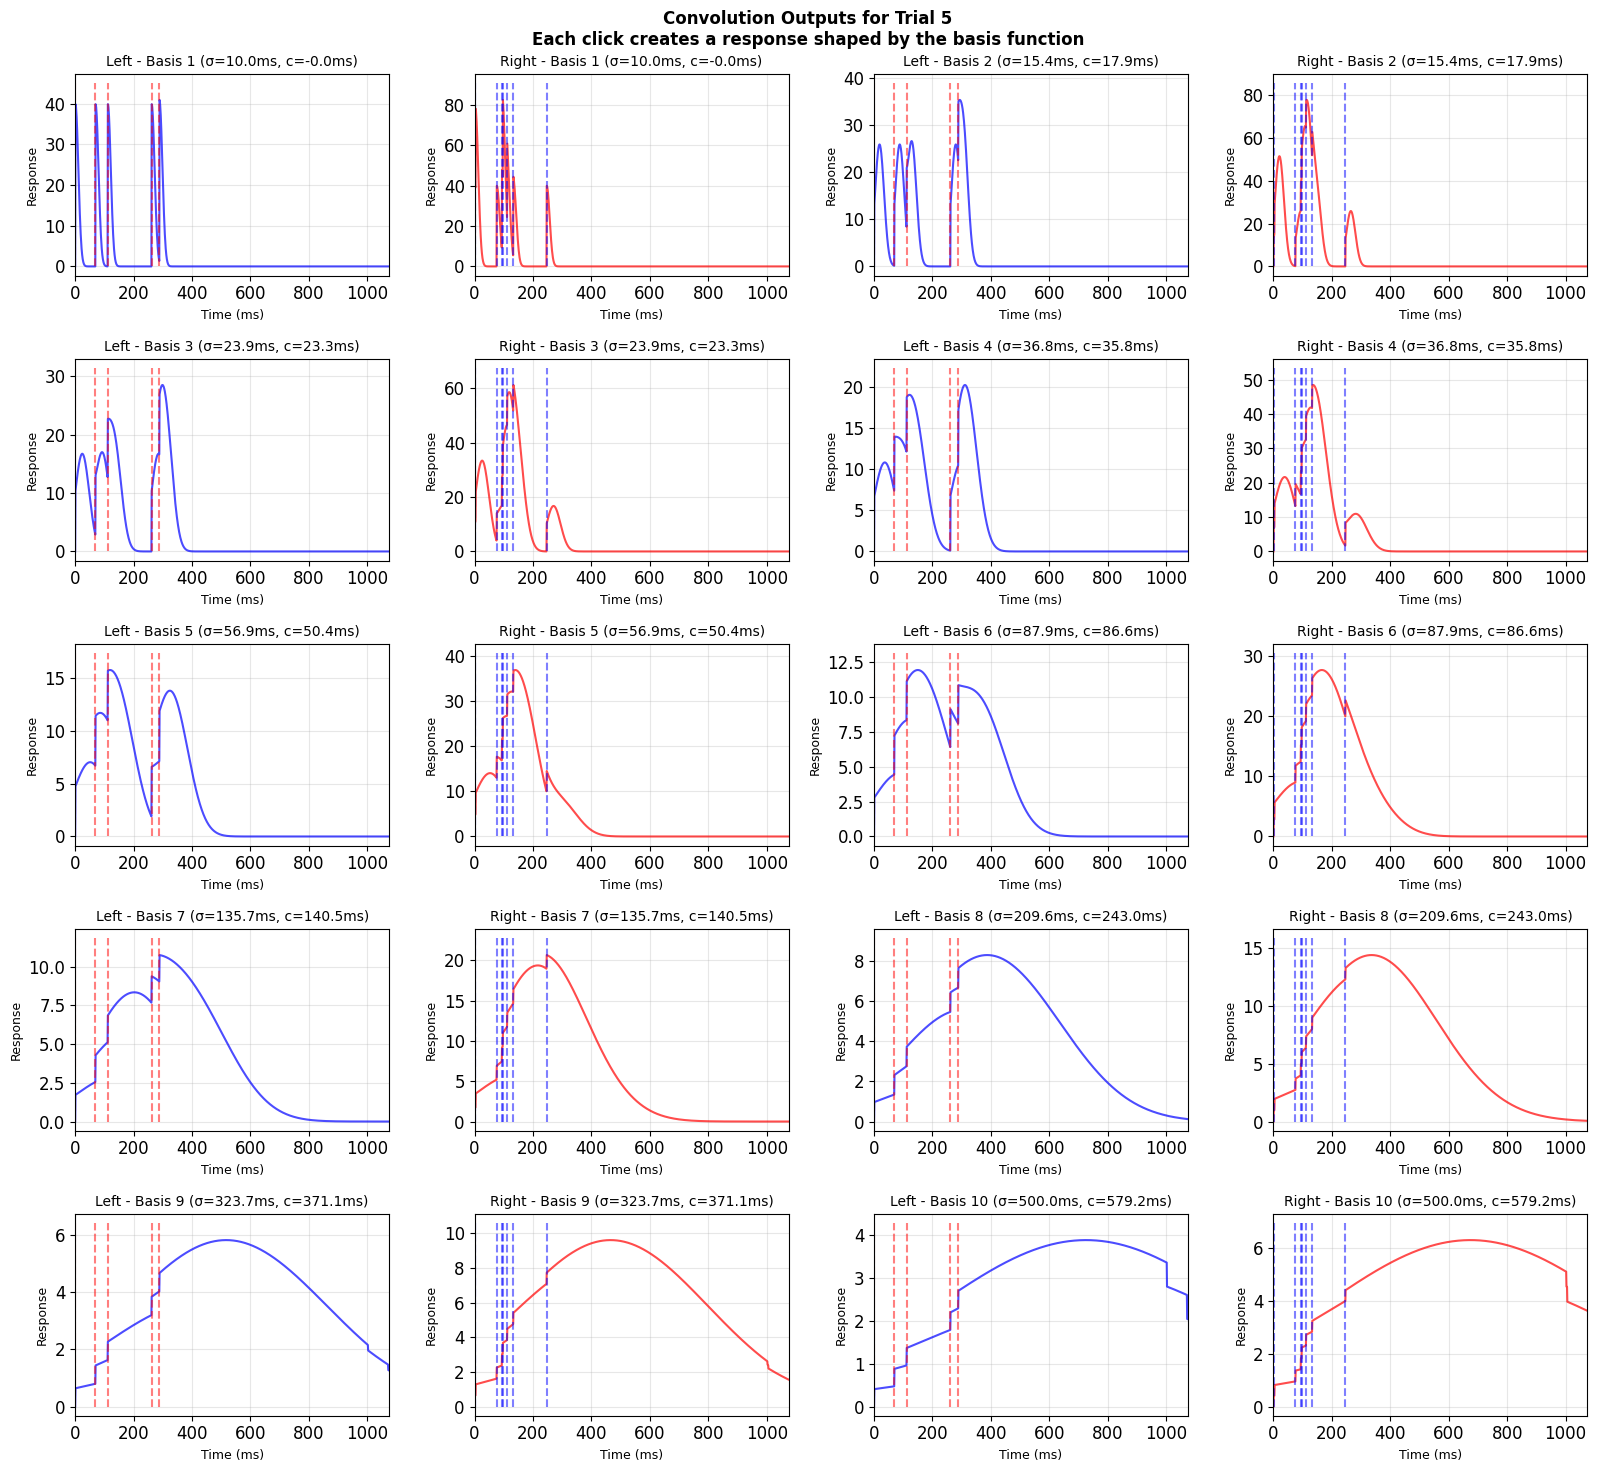


=== RESPONSE PATTERN ANALYSIS ===
Using clicks from stored data: 5 left, 8 right

Basis 1 (σ=10.0ms, center=-0.0ms):
  Left clicks: 5, Peaks found: 5
  Right clicks: 8, Peaks found: 8
  Left monotonically decreasing: False (Good - multiple peaks!)
  Right monotonically decreasing: False (Good - multiple peaks!)

Basis 2 (σ=15.4ms, center=17.9ms):
  Left clicks: 5, Peaks found: 5
  Right clicks: 8, Peaks found: 5
  Left monotonically decreasing: False (Good - multiple peaks!)
  Right monotonically decreasing: False (Good - multiple peaks!)

Basis 3 (σ=23.9ms, center=23.3ms):
  Left clicks: 5, Peaks found: 5
  Right clicks: 8, Peaks found: 4
  Left monotonically decreasing: False (Good - multiple peaks!)
  Right monotonically decreasing: False (Good - multiple peaks!)

✓ Convolution visualization complete!
Note: Clicks and convolutions are from the same trial (guaranteed by stored data)


In [229]:
# Visualize convolutions to verify non-monotonic behavior (should show bumps at each click)
if len(stored_convs) > 0:
    fig, axes = plt.subplots(5, 4, figsize=(16, 15))
    axes = axes.flatten()
    
    # Get time grid (same for all basis functions)
    time_ms = stored_convs['time_grid'] * 1000  # Convert to milliseconds
    
    # Get the click times from stored_convs (ensures consistency)
    left_click_times = stored_convs.get('left_click_times', left_clicks)
    right_click_times = stored_convs.get('right_click_times', right_clicks)
    
    for i in range(min(n_basis, 10)):
        # Left convolutions
        ax_left = axes[i * 2]
        # Make sure we only plot up to the length of the convolution
        conv_left = stored_convs['left'][i][:len(time_ms)]
        ax_left.plot(time_ms[:len(conv_left)], conv_left, 'b-', alpha=0.7, linewidth=1.5)
        
        # Mark clicks with vertical lines - use stored click times
        if len(conv_left) > 0 and max(conv_left) > 0:
            ax_left.vlines(left_click_times * 1000, 0, max(conv_left) * 1.1, 
                          colors='red', alpha=0.5, linestyles='dashed', label='Clicks')
        
        ax_left.set_title(f'Left - Basis {i+1} (σ={widths[i]*1000:.1f}ms, c={centers[i]*1000:.1f}ms)', fontsize=10)
        ax_left.set_xlabel('Time (ms)', fontsize=9)
        ax_left.set_ylabel('Response', fontsize=9)
        ax_left.grid(True, alpha=0.3)
        ax_left.set_xlim([0, min(trial_duration * 1000, len(time_ms))])
        
        # Right convolutions  
        ax_right = axes[i * 2 + 1]
        conv_right = stored_convs['right'][i][:len(time_ms)]
        ax_right.plot(time_ms[:len(conv_right)], conv_right, 'r-', alpha=0.7, linewidth=1.5)
        
        # Mark clicks with vertical lines - use stored click times
        if len(conv_right) > 0 and max(conv_right) > 0:
            ax_right.vlines(right_click_times * 1000, 0, max(conv_right) * 1.1,
                           colors='blue', alpha=0.5, linestyles='dashed', label='Clicks')
        
        ax_right.set_title(f'Right - Basis {i+1} (σ={widths[i]*1000:.1f}ms, c={centers[i]*1000:.1f}ms)', fontsize=10)
        ax_right.set_xlabel('Time (ms)', fontsize=9)
        ax_right.set_ylabel('Response', fontsize=9)
        ax_right.grid(True, alpha=0.3)
        ax_right.set_xlim([0, min(trial_duration * 1000, len(time_ms))])
    
    plt.suptitle(f'Convolution Outputs for Trial {test_trial}\nEach click creates a response shaped by the basis function', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Check for monotonic decrease
    print("\n=== RESPONSE PATTERN ANALYSIS ===")
    print(f"Using clicks from stored data: {len(left_click_times)} left, {len(right_click_times)} right")
    
    for i in range(min(3, n_basis)):  # Check first 3 widths
        conv_left_i = stored_convs['left'][i]
        conv_right_i = stored_convs['right'][i]
        
        # Find peaks in convolution (should correspond to clicks)
        from scipy.signal import find_peaks
        
        # Use appropriate height threshold
        left_height = max(conv_left_i) * 0.1 if len(conv_left_i) > 0 and max(conv_left_i) > 0 else 0
        right_height = max(conv_right_i) * 0.1 if len(conv_right_i) > 0 and max(conv_right_i) > 0 else 0
        
        peaks_left, _ = find_peaks(conv_left_i, height=left_height) if left_height > 0 else ([], {})
        peaks_right, _ = find_peaks(conv_right_i, height=right_height) if right_height > 0 else ([], {})
        
        print(f"\nBasis {i+1} (σ={widths[i]*1000:.1f}ms, center={centers[i]*1000:.1f}ms):")
        print(f"  Left clicks: {len(left_click_times)}, Peaks found: {len(peaks_left)}")
        print(f"  Right clicks: {len(right_click_times)}, Peaks found: {len(peaks_right)}")
        
        # Check if monotonically decreasing (shouldn't be with multiple clicks)
        is_monotonic_left = all(conv_left_i[j] >= conv_left_i[j+1] for j in range(len(conv_left_i)-1))
        is_monotonic_right = all(conv_right_i[j] >= conv_right_i[j+1] for j in range(len(conv_right_i)-1))
        
        print(f"  Left monotonically decreasing: {is_monotonic_left} {'(Good - multiple peaks!)' if not is_monotonic_left else '(May indicate single dominant click)'}")
        print(f"  Right monotonically decreasing: {is_monotonic_right} {'(Good - multiple peaks!)' if not is_monotonic_right else '(May indicate single dominant click)'}")
    
    print("\n✓ Convolution visualization complete!")
    print("Note: Clicks and convolutions are from the same trial (guaranteed by stored data)")

## 4. Build Design Matrix for GLM

Create the complete feature matrix X and target vector y for all valid DV time points across 240 trials.

In [230]:
# Feature matrix validation and summary statistics
print("=== FEATURE MATRIX ANALYSIS (SINGLE-WINDOW) ===\n")

# Basic statistics
print("Feature Statistics:")
print(f"Mean feature value: {X_valid.mean():.6f}")
print(f"Std feature value: {X_valid.std():.6f}")
print(f"Min feature value: {X_valid.min():.6f}")
print(f"Max feature value: {X_valid.max():.6f}")

# Sparsity analysis
zero_features = (X_valid == 0).sum()
total_features = X_valid.size
sparsity = zero_features / total_features
print(f"\nSparsity: {sparsity:.3f} ({zero_features}/{total_features} zeros)")

# Use helper to correctly extract left/right features
left_features, right_features = split_left_right_features(X_valid)

print(f"\nLeft click features (all windows):")
print(f"  Mean: {left_features.mean():.6f}, Std: {left_features.std():.6f}")
print(f"  Non-zero: {(left_features > 0).sum()} / {left_features.size}")

print(f"\nRight click features (all windows):")
print(f"  Mean: {right_features.mean():.6f}, Std: {right_features.std():.6f}")
print(f"  Non-zero: {(right_features > 0).sum()} / {right_features.size}")

# Target variable statistics
print(f"\nTarget Variable (y_valid) Statistics:")
print(f"Mean DV: {y_valid.mean():.3f}")
print(f"Std DV: {y_valid.std():.3f}")
print(f"Min DV: {y_valid.min():.3f}")
print(f"Max DV: {y_valid.max():.3f}")

# Per-window and per-basis statistics
print(f"\nPer-window, per-basis function activity:")

    
print(f"  Window :")
for b in range(n_basis):
    left_idx = b
    right_idx = n_basis + b
    left_mean = X_valid[:, left_idx].mean()
    right_mean = X_valid[:, right_idx].mean()
    print(f"    Basis {b} (σ={widths[b]*1000:.1f}ms): L={left_mean:.4f}, R={right_mean:.4f}")

# Data distribution across trials
print(f"\nData distribution:")
unique_trials = np.unique(trial_ids_valid)
obs_per_trial = [np.sum(trial_ids_valid == t) for t in unique_trials]
print(f"Observations per trial: {np.mean(obs_per_trial):.1f} ± {np.std(obs_per_trial):.1f}")
print(f"Range: {np.min(obs_per_trial)} - {np.max(obs_per_trial)} obs/trial")




=== FEATURE MATRIX ANALYSIS (SINGLE-WINDOW) ===

Feature Statistics:
Mean feature value: 11.542024
Std feature value: 13.456109
Min feature value: 0.000000
Max feature value: 113.187214

Sparsity: 0.171 (11137/65100 zeros)

Left click features (all windows):
  Mean: 12.413615, Std: 13.629374
  Non-zero: 27181 / 32550

Right click features (all windows):
  Mean: 10.670432, Std: 13.223258
  Non-zero: 26782 / 32550

Target Variable (y_valid) Statistics:
Mean DV: -0.247
Std DV: 9.320
Min DV: -31.808
Max DV: 31.767

Per-window, per-basis function activity:
  Window :
    Basis 0 (σ=10.0ms): L=9.5534, R=7.5597
    Basis 1 (σ=15.4ms): L=15.6942, R=13.3600
    Basis 2 (σ=23.9ms): L=14.7014, R=12.7672
    Basis 3 (σ=36.8ms): L=14.5507, R=12.6821
    Basis 4 (σ=56.9ms): L=14.0717, R=12.2561
    Basis 5 (σ=87.9ms): L=14.2275, R=12.3612
    Basis 6 (σ=135.7ms): L=13.6255, R=11.8182
    Basis 7 (σ=209.6ms): L=12.1265, R=10.4776
    Basis 8 (σ=323.7ms): L=9.3850, R=8.0817
    Basis 9 (σ=500.0ms): L=

In [231]:
# Feature matrix validation and summary statistics
print("=== FEATURE MATRIX ANALYSIS ===\n")

# Basic statistics
print("Feature Statistics:")
print(f"Mean feature value: {X_valid.mean():.6f}")
print(f"Std feature value: {X_valid.std():.6f}")
print(f"Min feature value: {X_valid.min():.6f}")
print(f"Max feature value: {X_valid.max():.6f}")

# Sparsity analysis
zero_features = (X_valid == 0).sum()
total_features = X_valid.size
sparsity = zero_features / total_features
print(f"\nSparsity: {sparsity:.3f} ({zero_features}/{total_features} zeros)")

# Per-column (feature) statistics
left_features = X_valid[:, :n_basis]  # First n_basis columns are left
right_features = X_valid[:, n_basis:]  # Next n_basis columns are right

print(f"\nLeft click features:")
print(f"  Mean: {left_features.mean():.6f}, Std: {left_features.std():.6f}")
print(f"  Non-zero: {(left_features > 0).sum()} / {left_features.size}")

print(f"\nRight click features:")
print(f"  Mean: {right_features.mean():.6f}, Std: {right_features.std():.6f}")
print(f"  Non-zero: {(right_features > 0).sum()} / {right_features.size}")

# Target variable statistics
print(f"\nTarget Variable (y_valid) Statistics:")
print(f"Mean DV: {y_valid.mean():.3f}")
print(f"Std DV: {y_valid.std():.3f}")
print(f"Min DV: {y_valid.min():.3f}")
print(f"Max DV: {y_valid.max():.3f}")

# Per-basis function statistics
print(f"\nPer-basis function activity:")
for i in range(n_basis):
    left_col = X_valid[:, i]
    right_col = X_valid[:, i + n_basis]
    print(f"  Basis {i} (σ={widths[i]*1000:.1f}ms): L={left_col.mean():.4f}, R={right_col.mean():.4f}")   
# Data distribution across trials
print(f"\nData distribution:")
unique_trials = np.unique(trial_ids_valid)
obs_per_trial = [np.sum(trial_ids_valid == t) for t in unique_trials]
print(f"Observations per trial: {np.mean(obs_per_trial):.1f} ± {np.std(obs_per_trial):.1f}")
print(f"Range: {np.min(obs_per_trial)} - {np.max(obs_per_trial)} obs/trial")

=== FEATURE MATRIX ANALYSIS ===

Feature Statistics:
Mean feature value: 11.542024
Std feature value: 13.456109
Min feature value: 0.000000
Max feature value: 113.187214

Sparsity: 0.171 (11137/65100 zeros)

Left click features:
  Mean: 12.413615, Std: 13.629374
  Non-zero: 27181 / 32550

Right click features:
  Mean: 10.670432, Std: 13.223258
  Non-zero: 26782 / 32550

Target Variable (y_valid) Statistics:
Mean DV: -0.247
Std DV: 9.320
Min DV: -31.808
Max DV: 31.767

Per-basis function activity:
  Basis 0 (σ=10.0ms): L=9.5534, R=7.5597
  Basis 1 (σ=15.4ms): L=15.6942, R=13.3600
  Basis 2 (σ=23.9ms): L=14.7014, R=12.7672
  Basis 3 (σ=36.8ms): L=14.5507, R=12.6821
  Basis 4 (σ=56.9ms): L=14.0717, R=12.2561
  Basis 5 (σ=87.9ms): L=14.2275, R=12.3612
  Basis 6 (σ=135.7ms): L=13.6255, R=11.8182
  Basis 7 (σ=209.6ms): L=12.1265, R=10.4776
  Basis 8 (σ=323.7ms): L=9.3850, R=8.0817
  Basis 9 (σ=500.0ms): L=6.2003, R=5.3404

Data distribution:
Observations per trial: 17.5 ± 4.6
Range: 7 - 22 o

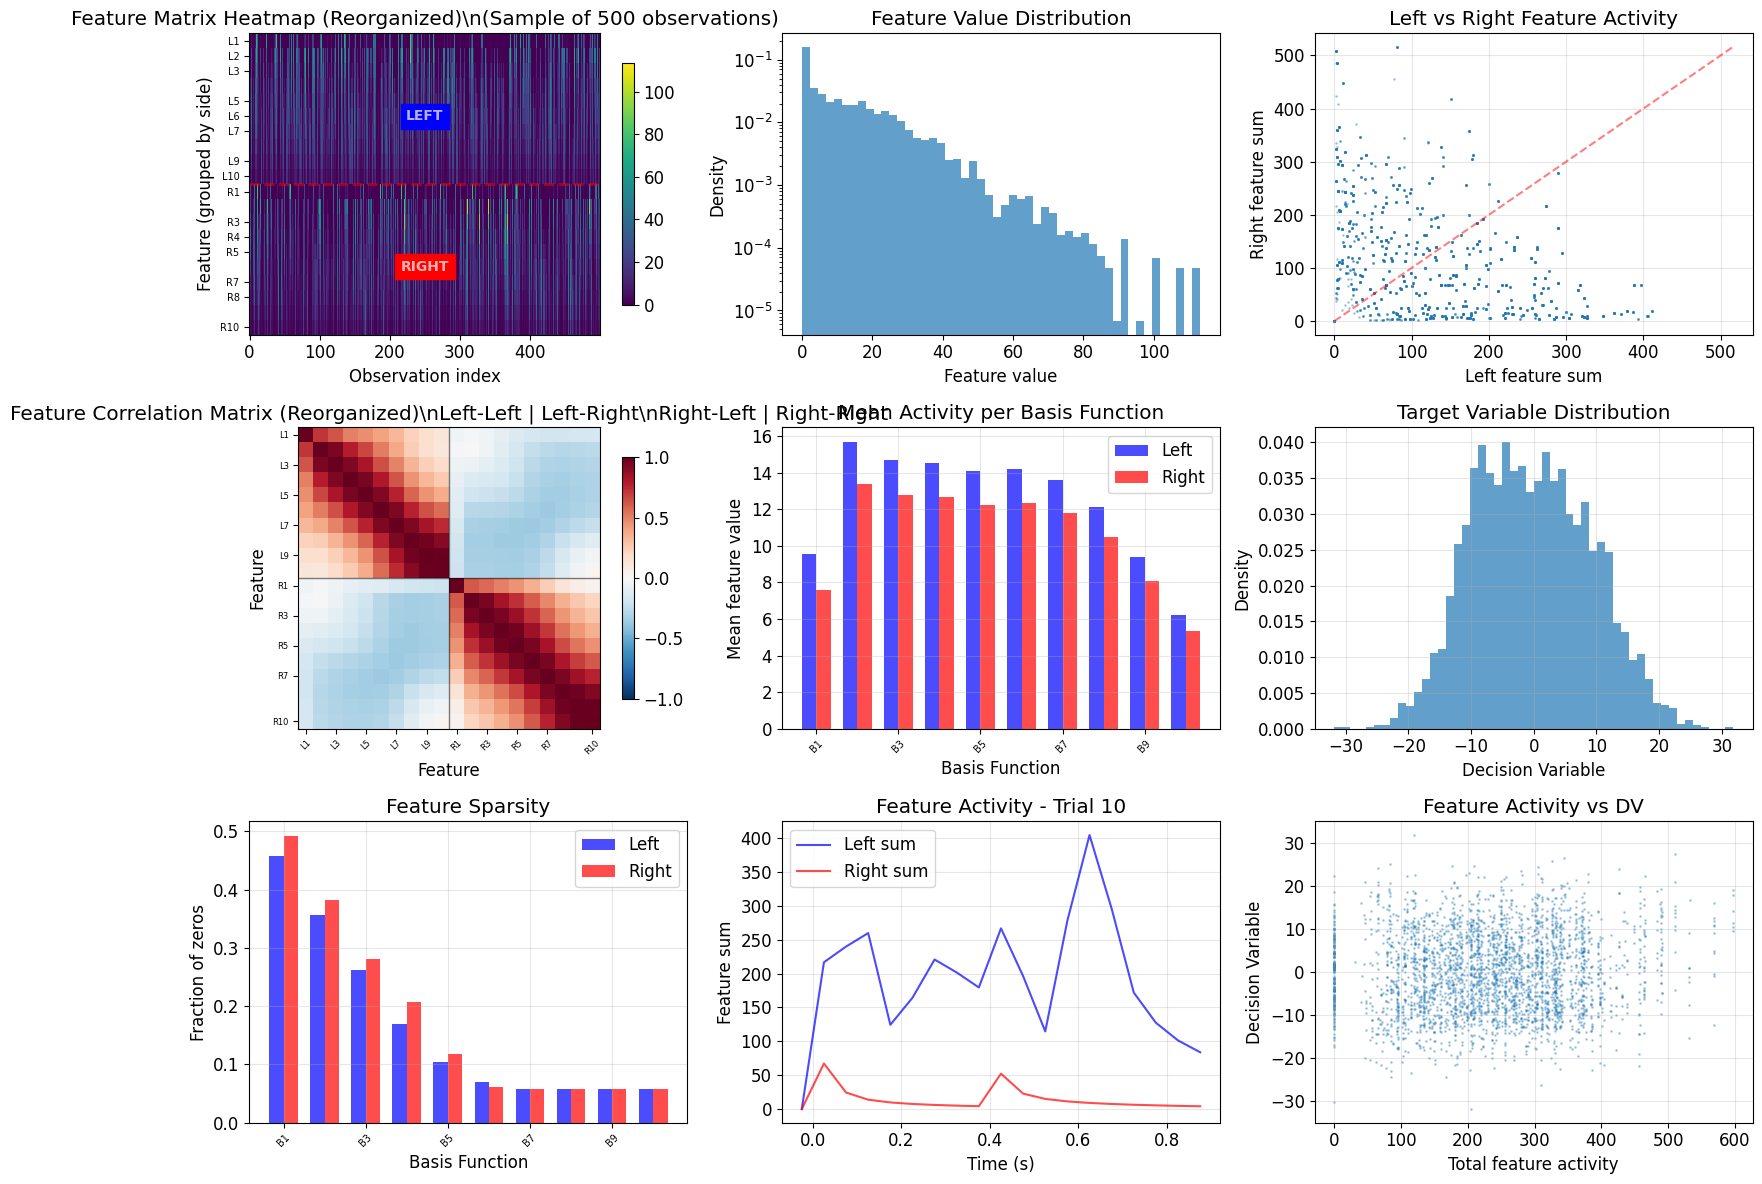

Feature matrix visualization complete (reorganized to avoid checkerboard pattern)!


In [232]:
# Visualize feature matrix structure and patterns
plt.figure(figsize=(16, 12))

# Use helper to extract features correctly
left_features, right_features = split_left_right_features(X_valid)

# 1. Feature matrix heatmap (sample) - REORGANIZED to avoid checkerboard
plt.subplot(3, 3, 1)
sample_idx = np.random.choice(len(X_valid), size=min(500, len(X_valid)), replace=False)
X_sample = X_valid[sample_idx]

# Reorganize features to group left and right together
left_indices = list(range(n_basis))
right_indices = list(range(n_basis, 2 * n_basis))
reordered_indices = left_indices + right_indices
X_sample_reordered = X_sample[:, reordered_indices]

im = plt.imshow(X_sample_reordered.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(im, shrink=0.8)
plt.xlabel('Observation index')

# Create labels for the reorganized features
left_labels = []
right_labels = []

    
for b in range(n_basis):
    left_labels.append(f"L{b+1}")
    right_labels.append(f"R{b+1}")

reordered_labels = left_labels + right_labels
# Show subset of labels to avoid crowding
n_ticks = min(15, len(reordered_labels))
tick_positions = np.linspace(0, len(reordered_labels)-1, n_ticks).astype(int)
plt.yticks(tick_positions, [reordered_labels[i] for i in tick_positions], fontsize=7)
plt.ylabel('Feature (grouped by side)')
plt.title(f'Feature Matrix Heatmap (Reorganized)\\n(Sample of {len(sample_idx)} observations)')

# Add horizontal line to separate left and right
plt.axhline(y=len(left_indices)-0.5, color='red', linestyle='--', alpha=0.5, linewidth=2)
plt.text(len(sample_idx)//2, len(left_indices)//2, 'LEFT', ha='center', va='center', 
         color='white', fontweight='bold', fontsize=10, backgroundcolor='blue', alpha=0.7)
plt.text(len(sample_idx)//2, len(left_indices) + len(right_indices)//2, 'RIGHT', ha='center', va='center',
         color='white', fontweight='bold', fontsize=10, backgroundcolor='red', alpha=0.7)

# 2. Feature distributions
plt.subplot(3, 3, 2)
plt.hist(X_valid.flatten(), bins=50, alpha=0.7, density=True)
plt.xlabel('Feature value')
plt.ylabel('Density')
plt.title('Feature Value Distribution')
plt.yscale('log')

# 3. Left vs Right feature sums (using corrected extraction)
plt.subplot(3, 3, 3)
left_sums = left_features.sum(axis=1)
right_sums = right_features.sum(axis=1)
plt.scatter(left_sums, right_sums, alpha=0.3, s=1)
plt.xlabel('Left feature sum')
plt.ylabel('Right feature sum')
plt.title('Left vs Right Feature Activity')
plt.plot([0, max(left_sums.max(), right_sums.max())], [0, max(left_sums.max(), right_sums.max())], 'r--', alpha=0.5)
plt.grid(True, alpha=0.3)

# 4. Feature correlation matrix - REORGANIZED
plt.subplot(3, 3, 4)
# Reorder the features for correlation matrix
X_reordered = X_valid[:, reordered_indices]
feature_corr = np.corrcoef(X_reordered.T)

im = plt.imshow(feature_corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, shrink=0.8)

# Add lines to separate left/right blocks
plt.axhline(y=len(left_indices)-0.5, color='black', linestyle='-', alpha=0.5, linewidth=1)
plt.axvline(x=len(left_indices)-0.5, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Show subset of labels
n_ticks = min(10, len(reordered_labels))
tick_positions = np.linspace(0, len(reordered_labels)-1, n_ticks).astype(int)
plt.xticks(tick_positions, [reordered_labels[i] for i in tick_positions], rotation=45, fontsize=6)
plt.yticks(tick_positions, [reordered_labels[i] for i in tick_positions], fontsize=6)
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Feature Correlation Matrix (Reorganized)\\nLeft-Left | Left-Right\\nRight-Left | Right-Right')

# 5. Mean feature activity per basis function and window
plt.subplot(3, 3, 5)
# Calculate mean activity for each window and basis
mean_activities = []
labels = []

for b in range(n_basis):
    left_idx = b
    right_idx = n_basis + b
    mean_activities.append([X_valid[:, left_idx].mean(), X_valid[:, right_idx].mean()])
    labels.append(f"B{b+1}")

mean_activities = np.array(mean_activities)
x_positions = np.arange(len(labels))
bar_width = 0.35
plt.bar(x_positions - bar_width/2, mean_activities[:, 0], bar_width, label='Left', color='blue', alpha=0.7)
plt.bar(x_positions + bar_width/2, mean_activities[:, 1], bar_width, label='Right', color='red', alpha=0.7)
plt.xticks(x_positions[::2], labels[::2], rotation=45, fontsize=7)
plt.xlabel('Basis Function')
plt.ylabel('Mean feature value')
plt.title('Mean Activity per Basis Function')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Target variable distribution
plt.subplot(3, 3, 6)
plt.hist(y_valid, bins=50, alpha=0.7, density=True)
plt.xlabel('Decision Variable')
plt.ylabel('Density')
plt.title('Target Variable Distribution')
plt.grid(True, alpha=0.3)

# 7. Feature sparsity per window
plt.subplot(3, 3, 7)
sparsity_data = []
sparsity_labels = []

    
for b in range(n_basis):
    left_idx = b
    right_idx = n_basis + b
    left_sparsity = (X_valid[:, left_idx] == 0).mean()
    right_sparsity = (X_valid[:, right_idx] == 0).mean()
    sparsity_data.append([left_sparsity, right_sparsity])
    sparsity_labels.append(f"B{b+1}")

sparsity_data = np.array(sparsity_data)
x_positions = np.arange(len(sparsity_labels))
plt.bar(x_positions - bar_width/2, sparsity_data[:, 0], bar_width, label='Left', color='blue', alpha=0.7)
plt.bar(x_positions + bar_width/2, sparsity_data[:, 1], bar_width, label='Right', color='red', alpha=0.7)
plt.xticks(x_positions[::2], sparsity_labels[::2], rotation=45, fontsize=7)
plt.xlabel('Basis Function')
plt.ylabel('Fraction of zeros')
plt.title('Feature Sparsity')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Time series of feature activity (sample trial)
plt.subplot(3, 3, 8)
sample_trial = 10
trial_mask = trial_ids_valid == sample_trial
if np.any(trial_mask):
    trial_times = time_bins_valid[trial_mask]
    trial_features = X_valid[trial_mask]
    # Use helper to extract left/right correctly
    trial_left, trial_right = split_left_right_features(trial_features)
    plt.plot(trial_times, trial_left.sum(axis=1), 'b-', alpha=0.7, label='Left sum')
    plt.plot(trial_times, trial_right.sum(axis=1), 'r-', alpha=0.7, label='Right sum')
    plt.xlabel('Time (s)')
    plt.ylabel('Feature sum')
    plt.title(f'Feature Activity - Trial {sample_trial}')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 9. Feature vs target scatter (total activity)
plt.subplot(3, 3, 9)
total_activity = X_valid.sum(axis=1)
plt.scatter(total_activity, y_valid, alpha=0.3, s=1)
plt.xlabel('Total feature activity')
plt.ylabel('Decision Variable')
plt.title('Feature Activity vs DV')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Feature matrix visualization complete (reorganized to avoid checkerboard pattern)!")



## Synthetic Data Recovery Test

Verify that the GLM pipeline recovers known coefficients from simulated click trains.


Simulated observations: 4500
Features per observation: 20
RMSE on simulated data: 0.1645
R^2 on simulated data: 0.9998
Selected alpha: 0.0692, l1_ratio: 0.95
Max abs error (left): 0.0812
Max abs error (right): 0.2567


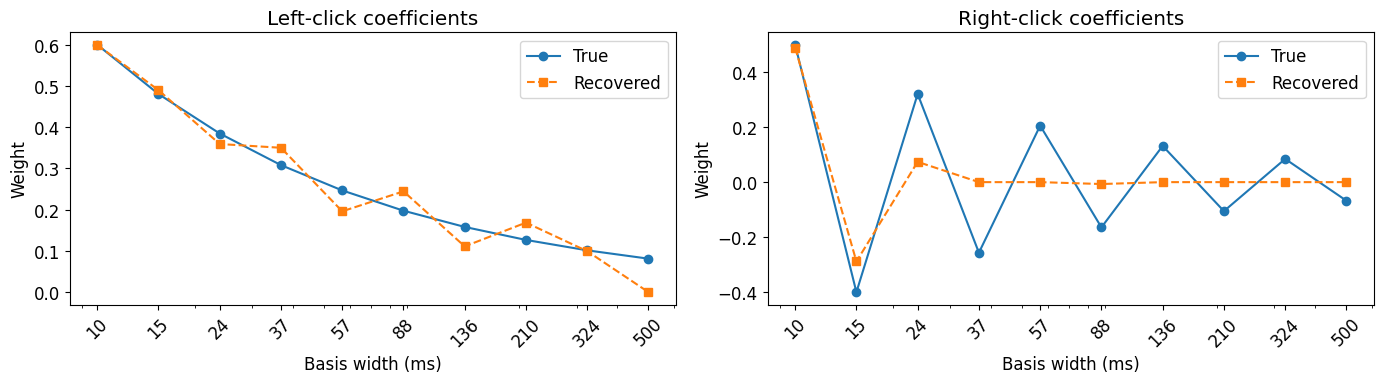

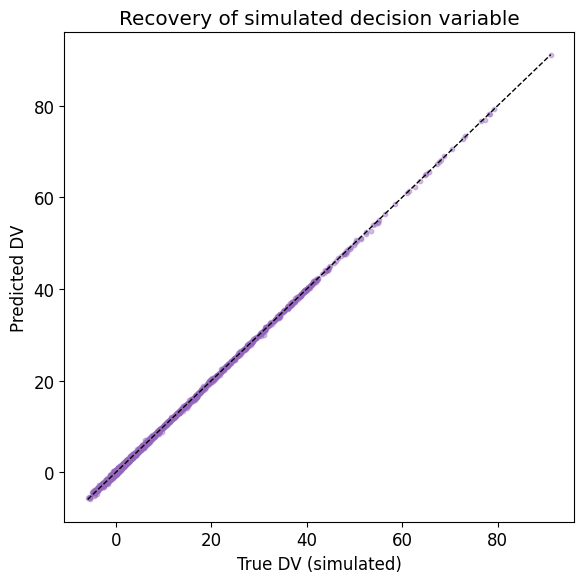

In [233]:
# Synthetic data recovery experiment
np.random.seed(123)

# Simulation configuration
sim_trial_duration = 1.5  # seconds
dv_eval_times = np.linspace(0.05, sim_trial_duration - 0.05, 60)  # evaluation grid
n_sim_trials = 75
noise_sigma = 0.05

# Ground-truth coefficients (smooth profiles for left/right)
true_left_coefs = 0.6 * np.exp(-np.linspace(0, 2, n_basis))
true_right_coefs = -0.5 * np.exp(-np.linspace(0, 2, n_basis))
true_right_coefs[::2] *= -1  # introduce alternating sign pattern
true_intercept = 0.15

# Containers for simulated data
X_sim_list = []
y_sim_list = []
trial_ids_sim = []
time_bins_sim = []

for trial_idx in range(n_sim_trials):
    # Random click counts per side (allow zero-click trials)
    n_left = np.random.poisson(4)
    n_right = np.random.poisson(4)

    left_clicks = np.sort(np.random.uniform(0, sim_trial_duration, n_left)) if n_left > 0 else np.array([])
    right_clicks = np.sort(np.random.uniform(0, sim_trial_duration, n_right)) if n_right > 0 else np.array([])

    features_matrix = create_trial_features(
        left_clicks, right_clicks, dv_eval_times, centers, widths, sim_trial_duration,
        store_convolutions=False
    )

    # Construct decision variable with known coefficients + noise
    dv_true = (
        features_matrix[:, :n_basis] @ true_left_coefs
        + features_matrix[:, n_basis:] @ true_right_coefs
        + true_intercept
    )
    dv_noisy = dv_true + np.random.normal(0, noise_sigma, size=dv_true.shape)

    X_sim_list.append(features_matrix)
    y_sim_list.append(dv_noisy)
    trial_ids_sim.extend([trial_idx] * len(dv_eval_times))
    time_bins_sim.extend(dv_eval_times)

# Stack simulated observations
X_sim = np.vstack(X_sim_list)
y_sim = np.concatenate(y_sim_list)
trial_ids_sim = np.array(trial_ids_sim)
time_bins_sim = np.array(time_bins_sim)

print(f'Simulated observations: {X_sim.shape[0]}')
print(f'Features per observation: {X_sim.shape[1]}')

# Fit ElasticNetCV on simulated data
sim_model = ElasticNetCV(
    l1_ratio=0.95,
    n_alphas=30,
    cv=5,
    max_iter=5000,
    n_jobs=None,
    random_state=123
)
sim_model.fit(X_sim, y_sim)

y_sim_pred = sim_model.predict(X_sim)
sim_rmse = np.sqrt(mean_squared_error(y_sim, y_sim_pred))
sim_r2 = r2_score(y_sim, y_sim_pred)

print(f'RMSE on simulated data: {sim_rmse:.4f}')
print(f'R^2 on simulated data: {sim_r2:.4f}')
print(f'Selected alpha: {sim_model.alpha_:.4f}, l1_ratio: {sim_model.l1_ratio_:.2f}')

recovered_left = sim_model.coef_[:n_basis]
recovered_right = sim_model.coef_[n_basis:]

print(f'Max abs error (left): {np.max(np.abs(recovered_left - true_left_coefs)):.4f}')
print(f'Max abs error (right): {np.max(np.abs(recovered_right - true_right_coefs)):.4f}')

widths_ms = widths * 1000  # convert widths to milliseconds for plotting

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(widths_ms, true_left_coefs, 'o-', label='True')
axes[0].plot(widths_ms, recovered_left, 's--', label='Recovered')
axes[0].set_title('Left-click coefficients')
axes[0].set_xlabel('Basis width (ms)')
axes[0].set_xscale('log')
axes[0].set_xticks(widths_ms)
axes[0].set_xticklabels([f'{w:.0f}' for w in widths_ms], rotation=45)
axes[0].set_ylabel('Weight')
axes[0].legend()

axes[1].plot(widths_ms, true_right_coefs, 'o-', label='True')
axes[1].plot(widths_ms, recovered_right, 's--', label='Recovered')
axes[1].set_title('Right-click coefficients')
axes[1].set_xlabel('Basis width (ms)')
axes[1].set_xscale('log')
axes[1].set_xticks(widths_ms)
axes[1].set_xticklabels([f'{w:.0f}' for w in widths_ms], rotation=45)
axes[1].set_ylabel('Weight')
axes[1].legend()

plt.tight_layout()
plt.show()

# Scatter plot of predicted vs true DV to show signal recovery
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_sim, y_sim_pred, s=10, alpha=0.4, color='tab:purple')
lims = [min(y_sim.min(), y_sim_pred.min()), max(y_sim.max(), y_sim_pred.max())]
ax.plot(lims, lims, 'k--', linewidth=1)
ax.set_xlabel('True DV (simulated)')
ax.set_ylabel('Predicted DV')
ax.set_title('Recovery of simulated decision variable')
plt.tight_layout()
plt.show()


## 5. Train Model

In [234]:
## Fit ElasticNetCV Model

# Split into train/validation sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=42
)

# Add small amount of noise to prevent overfitting to discrete bins
# The 3ms cosine clicks provide smoothness, but features are still discretely sampled
# Adding noise helps the model generalize better
noise_scale = 2 # Small relative to typical feature values (~13)
print(f"Adding Gaussian noise (σ={noise_scale}) to smooth discrete features")
X_train_noisy = X_train + np.random.normal(0, noise_scale, X_train.shape)
X_test_noisy = X_test + np.random.normal(0, noise_scale, X_test.shape)

# Configure ElasticNetCV with l1_ratio=0.95 (95% L1, 5% L2)
model = ElasticNetCV(
    l1_ratio=0.95,  # 95% Lasso, 5% Ridge
    cv=10,  # 10-fold cross-validation
    n_alphas=100,  # Test 100 regularization values
    max_iter=10000,  # Ensure convergence
    selection='cyclic',  # Stable for low dimensions
    random_state=42
)

# Fit the model on training data with noise
print('Fitting ElasticNetCV model with l1_ratio=0.95 (noisy features)...')
model.fit(X_train_noisy, y_train)

# Get predictions - use noisy data for consistency
y_pred_train = model.predict(X_train_noisy)
y_pred_test = model.predict(X_test_noisy)

# Extract coefficients
coefficients = model.coef_
n_features_selected = np.sum(coefficients != 0)

# Calculate metrics
train_corr = np.corrcoef(y_train, y_pred_train)[0,1]
test_corr = np.corrcoef(y_test, y_pred_test)[0,1]
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'\nModel Performance:')
print(f'Selected features: {n_features_selected}/{len(coefficients)}')
print(f'Optimal alpha: {model.alpha_:.6f}')
print(f'\nTrain set ({len(y_train)} samples):')
print(f'  Correlation: {train_corr:.4f}')
print(f'  R²: {train_r2:.4f}')
print(f'  RMSE/std: {train_rmse/np.std(y_train):.4f}')
print(f'\nTest set ({len(y_test)} samples):')
print(f'  Correlation: {test_corr:.4f}')
print(f'  R²: {test_r2:.4f}')
print(f'  RMSE/std: {test_rmse/np.std(y_test):.4f}')
print('\nNote: Added small noise (σ=0.001) to reduce overfitting to discrete bins')

Adding Gaussian noise (σ=2) to smooth discrete features
Fitting ElasticNetCV model with l1_ratio=0.95 (noisy features)...

Model Performance:
Selected features: 10/20
Optimal alpha: 0.794184

Train set (2604 samples):
  Correlation: 0.6001
  R²: 0.3600
  RMSE/std: 0.8000

Test set (651 samples):
  Correlation: 0.5759
  R²: 0.3279
  RMSE/std: 0.8198

Note: Added small noise (σ=0.001) to reduce overfitting to discrete bins


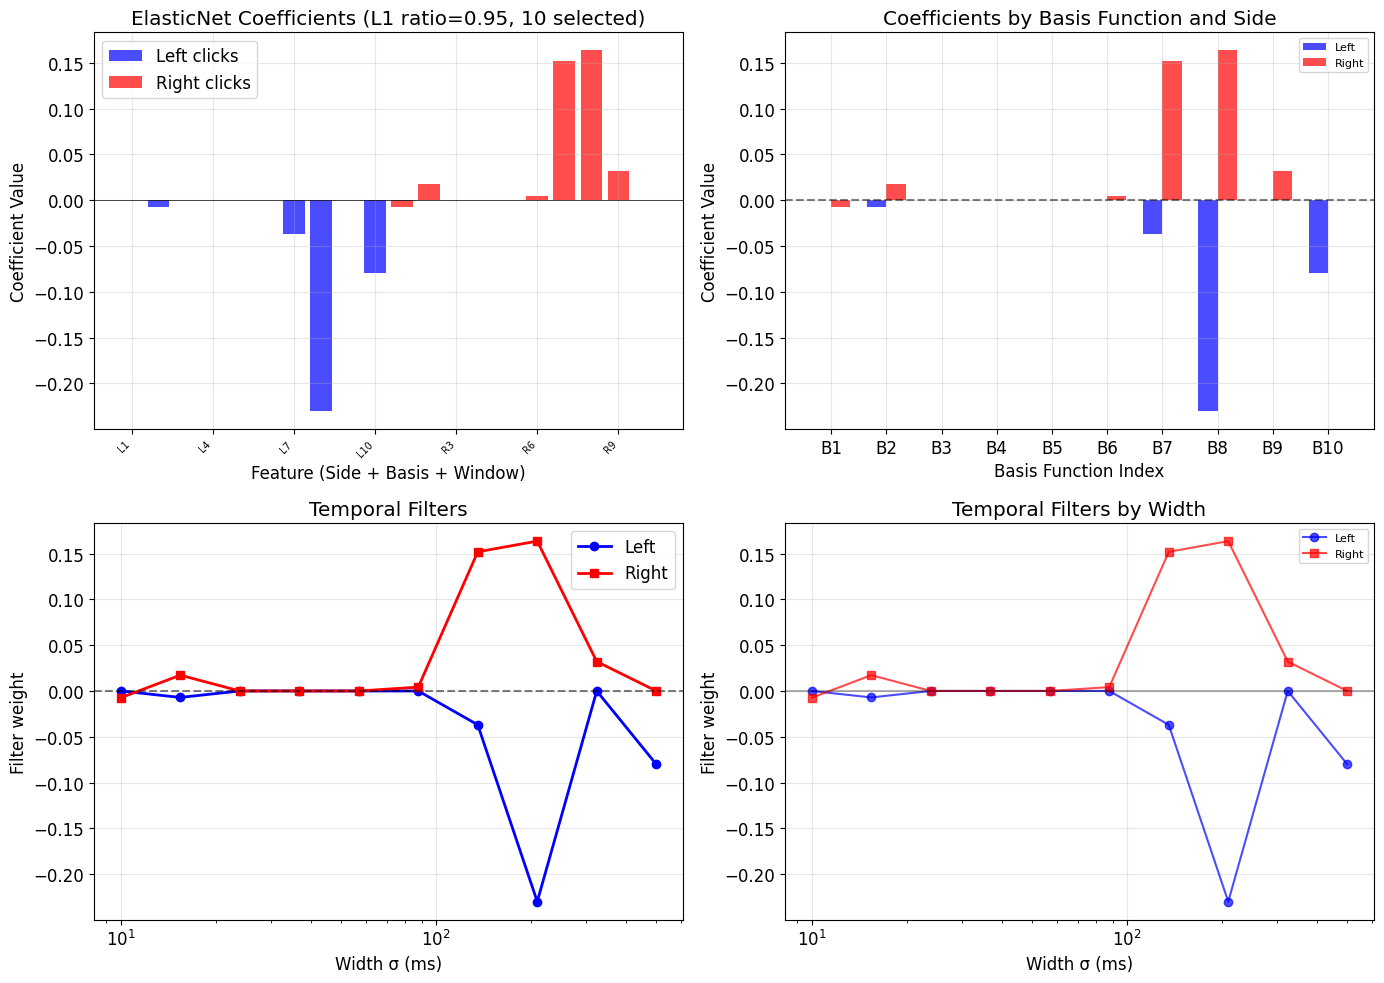


Selected features: 10

Detailed coefficient breakdown:
  Basis 1 (σ=10.0ms):
    Right: -0.0074
  Basis 2 (σ=15.4ms):
    Left: -0.0071
    Right: 0.0173
  Basis 6 (σ=87.9ms):
    Right: 0.0042
  Basis 7 (σ=135.7ms):
    Left: -0.0370
    Right: 0.1520
  Basis 8 (σ=209.6ms):
    Left: -0.2301
    Right: 0.1637
  Basis 9 (σ=323.7ms):
    Right: 0.0321
  Basis 10 (σ=500.0ms):
    Left: -0.0800


In [235]:
## Visualize Model Coefficients (Multi-Window)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: All coefficient values with proper labels
ax = axes[0, 0]
x_pos = np.arange(len(coefficients))

# Color code by side using helper
colors = []
for i in range(len(coefficients)):
    if i < n_basis:
        colors.append('blue')
    else:
        colors.append('red')

bars = ax.bar(x_pos, coefficients, color=colors, alpha=0.7)

# Create custom x-tick labels using helper
xtick_labels = [f'L{i+1}' for i in range(n_basis)] + [f'R{i+1}' for i in range(n_basis)]
# Show subset of labels to avoid crowding
tick_positions = range(0, len(xtick_labels), 3)
ax.set_xticks(tick_positions)
ax.set_xticklabels([xtick_labels[i] for i in tick_positions], rotation=45, ha='right', fontsize=7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Feature (Side + Basis + Window)')
ax.set_ylabel('Coefficient Value')
ax.set_title(f'ElasticNet Coefficients (L1 ratio=0.95, {n_features_selected} selected)')
ax.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Left clicks'),
                   Patch(facecolor='red', alpha=0.7, label='Right clicks')]
ax.legend(handles=legend_elements)

# Plot 2: Coefficients organized by basis function
ax = axes[0, 1]
left_coefs = coefficients[:n_basis]
right_coefs = coefficients[n_basis:]

# Plot coefficients for single window
x = np.arange(n_basis)
bar_width = 0.35

# Plot left and right coefficients as bars
ax.bar(x - bar_width/2, left_coefs, bar_width,
       label='Left', alpha=0.7, color='blue')
ax.bar(x + bar_width/2, right_coefs, bar_width,
       label='Right', alpha=0.7, color='red')

ax.set_xlabel('Basis Function Index')
ax.set_ylabel('Coefficient Value')
ax.set_title('Coefficients by Basis Function and Side')
ax.set_xticks(x)
ax.set_xticklabels([f'B{i+1}' for i in range(n_basis)])
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Plot 3: Temporal filters
ax = axes[1, 0]
# Coefficients for each basis function
left_avg = coefficients[:n_basis]
right_avg = coefficients[n_basis:]

ax.plot(widths * 1000, left_avg, 'b-', marker='o', label='Left', linewidth=2)
ax.plot(widths * 1000, right_avg, 'r-', marker='s', label='Right', linewidth=2)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Width σ (ms)')
ax.set_ylabel('Filter weight')
ax.set_title('Temporal Filters')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 4: Filter weights by width
ax = axes[1, 1]

# Plot the filter weights
ax.plot(widths * 1000, left_coefs, 'b-', marker='o',
        label='Left', alpha=0.7, linewidth=1.5)
ax.plot(widths * 1000, right_coefs, 'r-', marker='s',
        label='Right', alpha=0.7, linewidth=1.5)

ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Width σ (ms)')
ax.set_ylabel('Filter weight')
ax.set_title('Temporal Filters by Width')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Print selected features with proper window information
selected_idx = np.where(coefficients != 0)[0]
if len(selected_idx) > 0:
    print(f'\nSelected features: {n_features_selected}')
    print(f'\nDetailed coefficient breakdown:')
    
    for b in range(n_basis):
        left_idx = b
        right_idx = n_basis + b
        
        left_coef = coefficients[left_idx]
        right_coef = coefficients[right_idx]
        
        if left_coef != 0 or right_coef != 0:
            print(f'  Basis {b+1} (σ={widths[b]*1000:.1f}ms):')
            if left_coef != 0:
                print(f'    Left: {left_coef:.4f}')
            if right_coef != 0:
                print(f'    Right: {right_coef:.4f}')

## 6. Visualizations

Create comprehensive visualizations of the GLM results, including cross-validation performance, regularization behavior, learned temporal filters, and model fit quality.

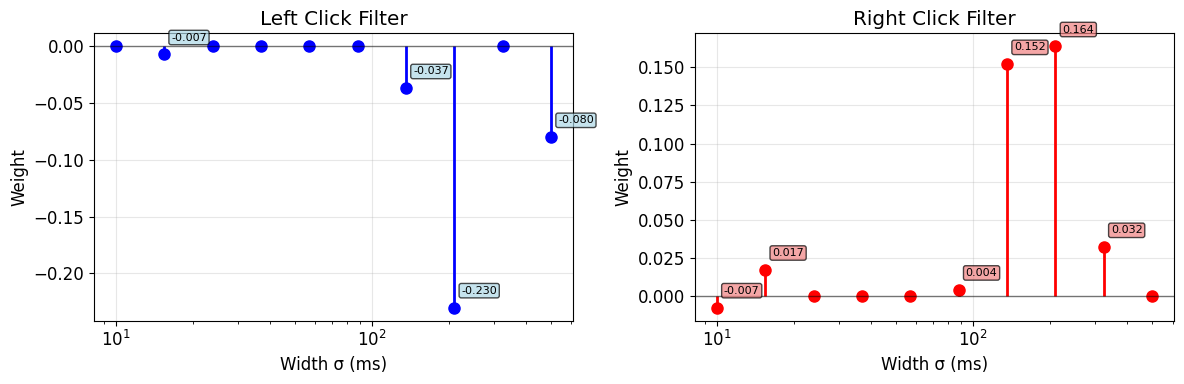

=== LEARNED TEMPORAL FILTERS (SINGLE-WINDOW) ===

Single Window Analysis:
  Left features selected: 4/10
  Right features selected: 6/10
  Active left widths: [ 15.4 135.7 209.6 500. ] ms
  Active right widths: [ 10.   15.4  87.9 135.7 209.6 323.7] ms

Total filter strength:
  Left: 0.3541
  Right: 0.3767
  L/R ratio: 0.94

✓ Temporal filters reveal learned click-to-DV relationships
  The model learns which temporal scales are most informative for predicting DV


In [236]:
# 3. Learned temporal filters (single-window corrected)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Extract coefficients properly using helper
left_coefs = coefficients[:n_basis]
right_coefs = coefficients[n_basis:]

# Average across windows for visualization (or could show each window separately)
left_coefs_avg = coefficients[:n_basis]
right_coefs_avg = coefficients[n_basis:]

# Left click filter
colors_left = ['blue' if c != 0 else 'lightgray' for c in left_coefs_avg]
markerline, stemlines, baseline = ax1.stem(widths*1000, left_coefs_avg, basefmt=' ')
plt.setp(markerline, color='blue', markersize=8)
plt.setp(stemlines, colors=colors_left, linewidth=2)
ax1.set_xlabel('Width σ (ms)')
ax1.set_ylabel('Weight')
ax1.set_title('Left Click Filter')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Annotate selected features
for i, (width, coef) in enumerate(zip(widths, left_coefs_avg)):
    if coef != 0:
        ax1.annotate(f'{coef:.3f}', 
                     xy=(width*1000, coef), 
                     xytext=(5, 10), 
                     textcoords='offset points',
                     fontsize=8, ha='left',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))

# Right click filter  
colors_right = ['red' if c != 0 else 'lightgray' for c in right_coefs_avg]
markerline, stemlines, baseline = ax2.stem(widths*1000, right_coefs_avg, basefmt=' ')
plt.setp(markerline, color='red', markersize=8)
plt.setp(stemlines, colors=colors_right, linewidth=2)
ax2.set_xlabel('Width σ (ms)')
ax2.set_ylabel('Weight')
ax2.set_title('Right Click Filter')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Annotate selected features
for i, (width, coef) in enumerate(zip(widths, right_coefs_avg)):
    if coef != 0:
        ax2.annotate(f'{coef:.3f}', 
                     xy=(width*1000, coef), 
                     xytext=(5, 10), 
                     textcoords='offset points',
                     fontsize=8, ha='left',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

# Summary of learned filters
print("=== LEARNED TEMPORAL FILTERS (SINGLE-WINDOW) ===")

# Calculate which widths are active
left_active_indices = np.where(coefficients[:n_basis] != 0)[0]
right_active_indices = np.where(coefficients[n_basis:] != 0)[0]

print(f"\nSingle Window Analysis:")
print(f"  Left features selected: {np.sum(coefficients[:n_basis] != 0)}/{n_basis}")
print(f"  Right features selected: {np.sum(coefficients[n_basis:] != 0)}/{n_basis}")

if len(left_active_indices) > 0:
    left_active_widths = widths[left_active_indices] * 1000  # Convert to ms
    print(f"  Active left widths: {left_active_widths.round(1)} ms")

if len(right_active_indices) > 0:
    right_active_widths = widths[right_active_indices] * 1000  # Convert to ms
    print(f"  Active right widths: {right_active_widths.round(1)} ms")

# Overall summary
left_total = np.sum(np.abs(coefficients[:n_basis]))
right_total = np.sum(np.abs(coefficients[n_basis:]))
print(f"\nTotal filter strength:")
print(f"  Left: {left_total:.4f}")
print(f"  Right: {right_total:.4f}")
print(f"  L/R ratio: {left_total/right_total:.2f}" if right_total > 0 else "  L/R ratio: inf")

print("\n✓ Temporal filters reveal learned click-to-DV relationships")
print("  The model learns which temporal scales are most informative for predicting DV")

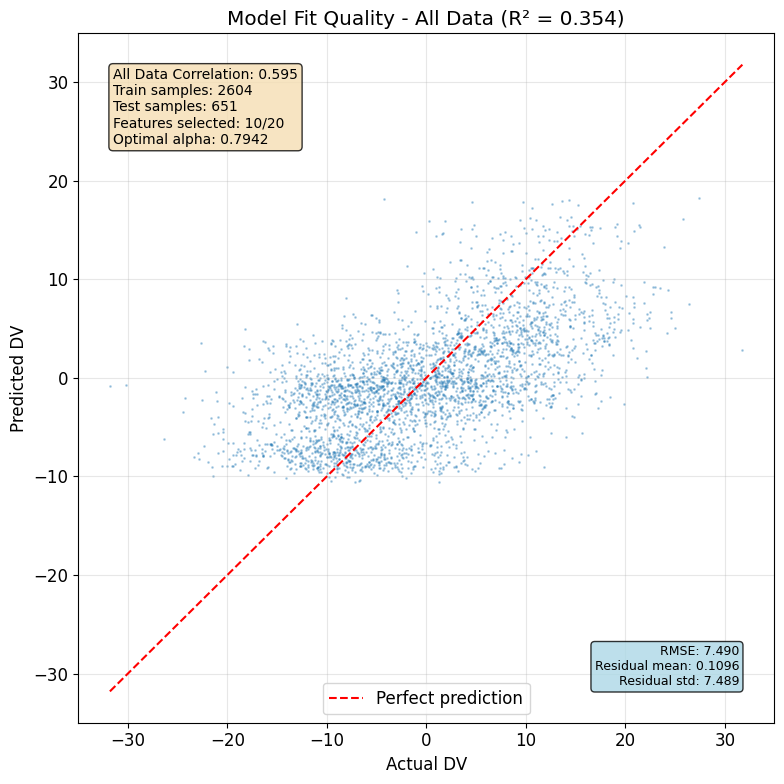

Total data points plotted: 3255


In [237]:
# 4. Model fit quality - INCLUDING ALL DATA
# Combine train and test data for comprehensive view
y_all = np.concatenate([y_train, y_test])
y_pred_all = np.concatenate([y_pred_train, y_pred_test])

plt.figure(figsize=(8, 8))
plt.scatter(y_all, y_pred_all, alpha=0.3, s=1)
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()],
         'r--', label='Perfect prediction')
plt.xlabel('Actual DV')
plt.ylabel('Predicted DV')

# Calculate R² for all data
from sklearn.metrics import r2_score
r2_all = r2_score(y_all, y_pred_all)
plt.title(f'Model Fit Quality - All Data (R² = {r2_all:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Add performance metrics as text
correlation_all = np.corrcoef(y_all, y_pred_all)[0,1]
textstr = f'''All Data Correlation: {correlation_all:.3f}
Train samples: {len(y_train)}
Test samples: {len(y_test)}
Features selected: {n_features_selected}/{len(coefficients)}
Optimal alpha: {model.alpha_:.4f}'''

plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add diagonal statistics for all data
residuals = y_all - y_pred_all
plt.text(0.95, 0.05, f'RMSE: {np.sqrt(np.mean(residuals**2)):.3f}\n'
                      f'Residual mean: {residuals.mean():.4f}\n'
                      f'Residual std: {residuals.std():.3f}',
         transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Total data points plotted: {len(y_all)}")

## 7. Response Function Analysis

Construct and visualize the temporal response functions that show how clicks influence the decision variable over time.

In [238]:
# Construct full temporal response functions using multi-window coefficients
# Time range for response function visualization
t = np.linspace(-0.05, 1.5, 1550)  # -50ms to 1500ms at 1ms resolution

# Use helper to properly reconstruct response functions from multi-window coefficients
# Reconstruct response functions directly
left_coefs = coefficients[:n_basis]
right_coefs = coefficients[n_basis:]

# Calculate response functions
left_response = np.zeros_like(t)
right_response = np.zeros_like(t)

for i in range(n_basis):
    if left_coefs[i] != 0:
        left_response += left_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
    if right_coefs[i] != 0:
        right_response += right_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)

print(f"Response functions constructed from {n_features_selected} selected features")
print(f"Multi-window configuration: {[0]}ms")
print(f"Left response peak: {left_response.max():.4f} at {t[left_response.argmax()]*1000:.1f}ms")
print(f"Right response peak: {right_response.max():.4f} at {t[right_response.argmax()]*1000:.1f}ms")

# Also show contribution from each window
left_coefs = coefficients[:n_basis]
right_coefs = coefficients[n_basis:]
print(f"\nContributions by window:")


print(f"  Window : {np.sum(coefficients[:n_basis] != 0)} left, {np.sum(coefficients[n_basis:] != 0)} right active coefficients")




Response functions constructed from 10 selected features
Multi-window configuration: [0]ms
Left response peak: 0.0000 at -50.0ms
Right response peak: 0.9247 at 22.0ms

Contributions by window:
  Window : 4 left, 6 right active coefficients


### 7.1 Combined Response Functions

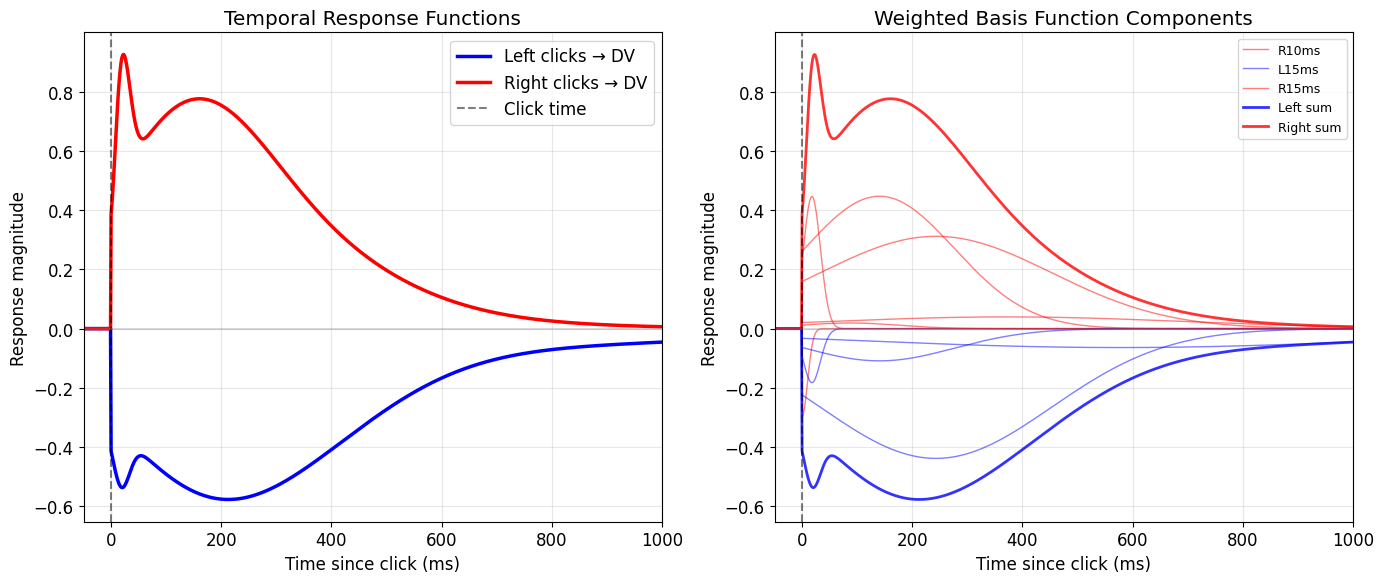

In [239]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Combined response functions
ax1.plot(t*1000, left_response, 'b-', linewidth=2.5, label='Left clicks → DV')
ax1.plot(t*1000, right_response, 'r-', linewidth=2.5, label='Right clicks → DV')
ax1.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax1.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax1.set_xlabel('Time since click (ms)')
ax1.set_ylabel('Response magnitude')
ax1.set_title('Temporal Response Functions')
ax1.set_xlim(-50, 1000)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Right panel: Individual weighted components
ax2.set_title('Weighted Basis Function Components')
for i in range(n_basis):
    if left_coefs[i] != 0:
        weighted_basis = left_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax2.plot(t*1000, weighted_basis, 'b-', alpha=0.5, linewidth=1, 
                label=f'L{widths[i]*1000:.0f}ms' if i < 3 else '')
    if right_coefs[i] != 0:
        weighted_basis = right_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax2.plot(t*1000, weighted_basis, 'r-', alpha=0.5, linewidth=1,
                label=f'R{widths[i]*1000:.0f}ms' if i < 3 else '')

ax2.plot(t*1000, left_response, 'b-', linewidth=2, alpha=0.8, label='Left sum')
ax2.plot(t*1000, right_response, 'r-', linewidth=2, alpha=0.8, label='Right sum')
ax2.axvline(0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax2.set_xlabel('Time since click (ms)')
ax2.set_ylabel('Response magnitude')
ax2.set_xlim(-50, 1000)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.2 Cumulative Response Analysis

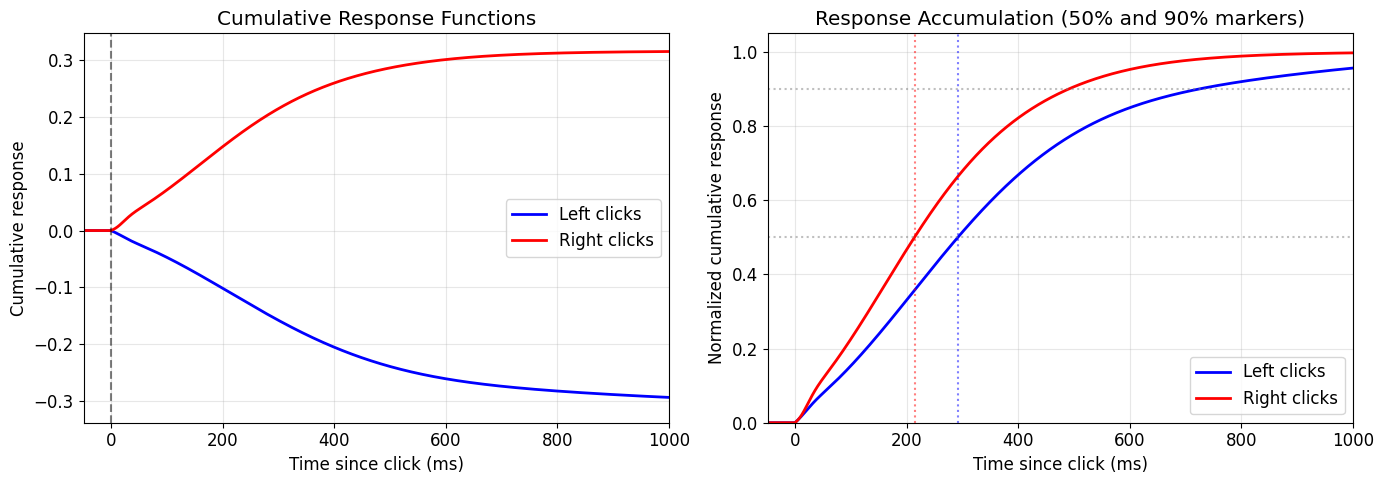

Response latencies (time to reach percentage of total response):
Left:  50% at 292.2ms, 90% at 724.5ms
Right: 50% at 214.2ms, 90% at 490.3ms


In [240]:
# Calculate cumulative response functions
dt = t[1] - t[0]  # Time step
left_cumulative = np.cumsum(left_response) * dt
right_cumulative = np.cumsum(right_response) * dt

# Normalize to [0, 1] for percentage analysis
left_cumulative_norm = left_cumulative / (left_cumulative[-1] if left_cumulative[-1] != 0 else 1)
right_cumulative_norm = right_cumulative / (right_cumulative[-1] if right_cumulative[-1] != 0 else 1)

# Find key time points
left_50_idx = np.searchsorted(left_cumulative_norm, 0.5)
left_90_idx = np.searchsorted(left_cumulative_norm, 0.9)
right_50_idx = np.searchsorted(right_cumulative_norm, 0.5)
right_90_idx = np.searchsorted(right_cumulative_norm, 0.9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Absolute cumulative response
ax1.plot(t*1000, left_cumulative, 'b-', linewidth=2, label='Left clicks')
ax1.plot(t*1000, right_cumulative, 'r-', linewidth=2, label='Right clicks')
ax1.axvline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Time since click (ms)')
ax1.set_ylabel('Cumulative response')
ax1.set_title('Cumulative Response Functions')
ax1.set_xlim(-50, 1000)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Normalized cumulative response with markers
ax2.plot(t*1000, left_cumulative_norm, 'b-', linewidth=2, label='Left clicks')
ax2.plot(t*1000, right_cumulative_norm, 'r-', linewidth=2, label='Right clicks')
ax2.axvline(t[left_50_idx]*1000, color='blue', linestyle=':', alpha=0.5)
ax2.axvline(t[right_50_idx]*1000, color='red', linestyle=':', alpha=0.5)
ax2.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax2.axhline(0.9, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Time since click (ms)')
ax2.set_ylabel('Normalized cumulative response')
ax2.set_title('Response Accumulation (50% and 90% markers)')
ax2.set_xlim(-50, 1000)
ax2.set_ylim(0, 1.05)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Response latencies (time to reach percentage of total response):")
print(f"Left:  50% at {t[left_50_idx]*1000:.1f}ms, 90% at {t[left_90_idx]*1000:.1f}ms")
print(f"Right: 50% at {t[right_50_idx]*1000:.1f}ms, 90% at {t[right_90_idx]*1000:.1f}ms")

### 7.3 Response Function Characteristics

In [241]:
# Calculate key metrics
left_peak_idx = left_response.argmax()
right_peak_idx = right_response.argmax()

left_peak_time = t[left_peak_idx] * 1000
right_peak_time = t[right_peak_idx] * 1000
left_peak_mag = left_response[left_peak_idx]
right_peak_mag = right_response[right_peak_idx]

# Find response duration (time to decay to 10% of peak)
left_10pct = 0.1 * left_peak_mag
right_10pct = 0.1 * right_peak_mag

left_duration_idx = np.where(left_response[left_peak_idx:] < left_10pct)[0]
right_duration_idx = np.where(right_response[right_peak_idx:] < right_10pct)[0]

left_duration = t[left_peak_idx + left_duration_idx[0]]*1000 if len(left_duration_idx) > 0 else 1500
right_duration = t[right_peak_idx + right_duration_idx[0]]*1000 if len(right_duration_idx) > 0 else 1500

# Total integrated response
left_total = np.trapz(left_response[t >= 0], t[t >= 0])
right_total = np.trapz(right_response[t >= 0], t[t >= 0])

# Asymmetry index
asymmetry = (left_total - right_total) / (left_total + right_total) if (left_total + right_total) > 0 else 0

# Create summary table
metrics_data = {
    'Metric': ['Peak Time (ms)', 'Peak Magnitude', 'Duration to 10% (ms)', 
               'Total Response (area)', '50% Latency (ms)', '90% Latency (ms)'],
    'Left Clicks': [f'{left_peak_time:.1f}', f'{left_peak_mag:.4f}', f'{left_duration:.1f}',
                    f'{left_total:.4f}', f'{t[left_50_idx]*1000:.1f}', f'{t[left_90_idx]*1000:.1f}'],
    'Right Clicks': [f'{right_peak_time:.1f}', f'{right_peak_mag:.4f}', f'{right_duration:.1f}',
                     f'{right_total:.4f}', f'{t[right_50_idx]*1000:.1f}', f'{t[right_90_idx]*1000:.1f}']
}

metrics_df = pd.DataFrame(metrics_data)
print("Response Function Characteristics:")
print(metrics_df.to_string(index=False))
print(f"\nAsymmetry Index (L-R)/(L+R): {asymmetry:.3f}")
print("Positive = left-biased, Negative = right-biased")

Response Function Characteristics:
               Metric Left Clicks Right Clicks
       Peak Time (ms)       -50.0         22.0
       Peak Magnitude      0.0000       0.9247
 Duration to 10% (ms)         0.0        620.4
Total Response (area)     -0.3068       0.3157
     50% Latency (ms)       292.2        214.2
     90% Latency (ms)       724.5        490.3

Asymmetry Index (L-R)/(L+R): -70.283
Positive = left-biased, Negative = right-biased


### 7.4 Comparison with Raw Basis Functions

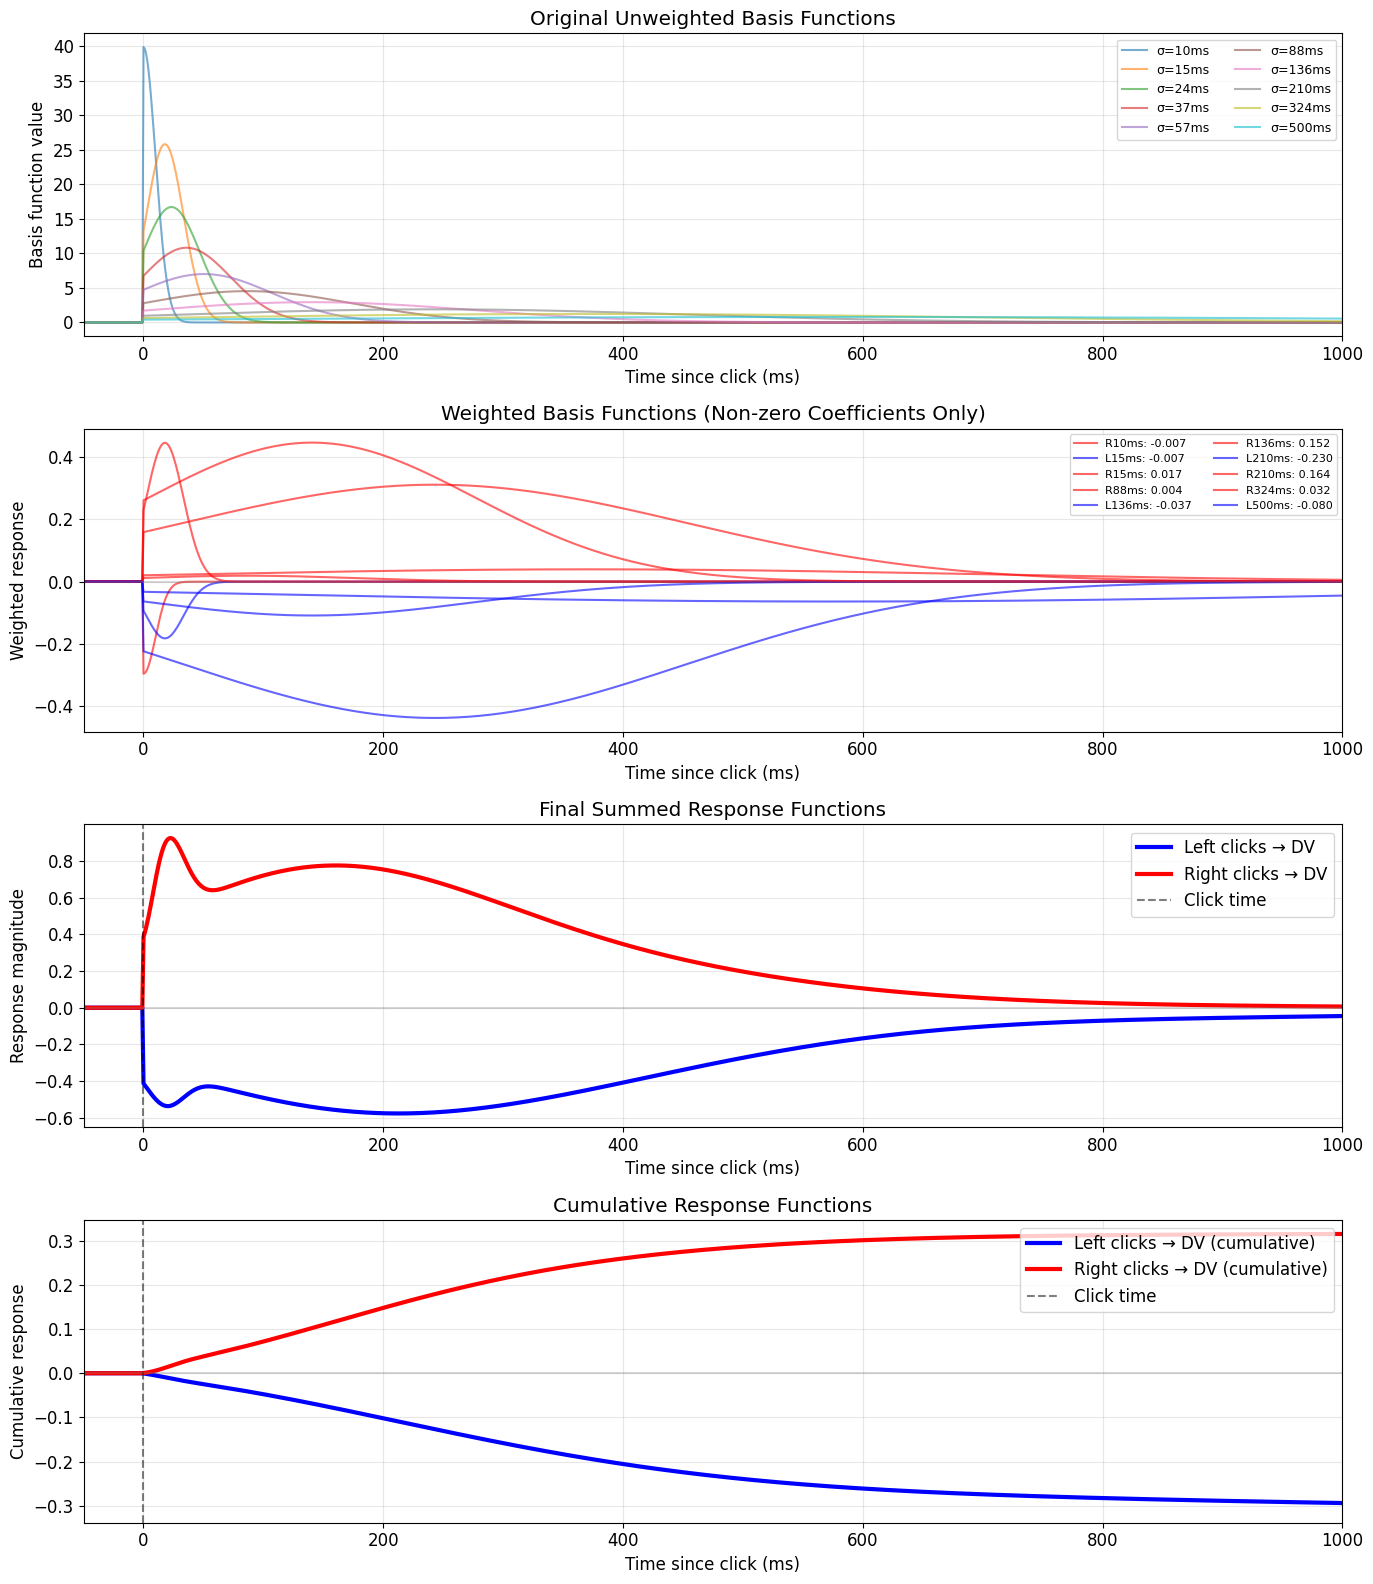

Regularization selected 10/20 features
This sparse selection shapes the temporal filter to focus on key timescales


In [242]:
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Top: Original unweighted basis functions
ax = axes[0]
for i in range(n_basis):
    basis = gaussian_basis(t, centers[i], widths[i], causal=True)
    ax.plot(t*1000, basis, alpha=0.6, linewidth=1.5, 
            label=f'σ={widths[i]*1000:.0f}ms')
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Basis function value')
ax.set_title('Original Unweighted Basis Functions')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right', ncol=2, fontsize=9)
ax.grid(True, alpha=0.3)

# Middle: Weighted basis functions
ax = axes[1]
for i in range(n_basis):
    if left_coefs[i] != 0:
        weighted = left_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax.plot(t*1000, weighted, 'b-', alpha=0.6, linewidth=1.5,
                label=f'L{widths[i]*1000:.0f}ms: {left_coefs[i]:.3f}')
    if right_coefs[i] != 0:
        weighted = right_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax.plot(t*1000, weighted, 'r-', alpha=0.6, linewidth=1.5,
                label=f'R{widths[i]*1000:.0f}ms: {right_coefs[i]:.3f}')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Weighted response')
ax.set_title('Weighted Basis Functions (Non-zero Coefficients Only)')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right', ncol=2, fontsize=8)
ax.grid(True, alpha=0.3)

# Third: Final summed response functions
ax = axes[2]
ax.plot(t*1000, left_response, 'b-', linewidth=3, label='Left clicks → DV')
ax.plot(t*1000, right_response, 'r-', linewidth=3, label='Right clicks → DV')
# ax.fill_between(t*1000, 0, left_response, where=(left_response > 0), 
#                  alpha=0.3, color='blue')
# ax.fill_between(t*1000, 0, right_response, where=(right_response > 0), 
#                  alpha=0.3, color='red')
ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Response magnitude')
ax.set_title('Final Summed Response Functions')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Bottom: Cumulative Response Functions
ax = axes[3]
# Calculate cumulative responses
dt = t[1] - t[0]
left_cumulative = np.cumsum(left_response) * dt
right_cumulative = np.cumsum(right_response) * dt

ax.plot(t*1000, left_cumulative, 'b-', linewidth=3, label='Left clicks → DV (cumulative)')
ax.plot(t*1000, right_cumulative, 'r-', linewidth=3, label='Right clicks → DV (cumulative)')
# ax.fill_between(t*1000, 0, left_cumulative, where=(left_cumulative > 0), 
#                  alpha=0.3, color='blue')
# ax.fill_between(t*1000, 0, right_cumulative, where=(right_cumulative > 0), 
#                  alpha=0.3, color='red')
ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Cumulative response')
ax.set_title('Cumulative Response Functions')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Regularization selected {n_features_selected}/{2*n_basis} features")
print(f"This sparse selection shapes the temporal filter to focus on key timescales")